# HPC Project: GPU Acceleration Analysis
## Academic Title: Performance Analysis of Parallel Matrix Computation using CUDA-Enabled GPUs

**Student Name:** [Your Name]  
**Course:** High Performance Computing (MSc)  
**Date:** [Today's Date]

---

### Abstract
This notebook demonstrates the significant performance advantages of GPU acceleration over CPU for computationally intensive tasks. Specifically, we benchmark large-scale Matrix Multiplication ($C = A \times B$) using **NVIDIA CUDA** cores via the **CuPy** library, comparing it against the CPU-based **NumPy** implementation. Results typically show a speedup of **50x to 1000x** depending on matrix size.

### Step 1: System Check (GPU Availability)

In [38]:
!nvidia-smi

Wed Dec 31 20:17:42 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P0             27W /   70W |    1198MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Step 2: Install/Verify Dependencies
Google Colab typically creates an environment where CuPy is pre-installed or easily installable.

In [39]:
import sys
import subprocess

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

try:
    import cupy as cp
    print("CuPy is already installed.")
    print(f"CuPy Version: {cp.__version__}")
except ImportError:
    print("Installing CuPy...")
    install("cupy-cuda12x")  # Adjust CUDA version if necessary for Colab runtime
    import cupy as cp

import numpy as np
import time
import matplotlib.pyplot as plt
print("Libraries loaded successfully.")

CuPy is already installed.
CuPy Version: 13.6.0
Libraries loaded successfully.


### Step 3: CPU Implementation (NumPy)
We define a function for CPU-based matrix multiplication.

In [41]:
def run_cpu_benchmark(size):
    """
    Performs Matrix Multiplication on CPU using NumPy.
    """
    print(f"[CPU] Allocating {size}x{size} matrices...")
    A = np.random.rand(size, size).astype(np.float32)
    B = np.random.rand(size, size).astype(np.float32)

    print(f"[CPU] Starting computation for N={size}...")
    start_time = time.time()
    C = np.dot(A, B)
    end_time = time.time()

    execution_time = end_time - start_time
    print(f"[CPU] Finished in {execution_time:.4f} seconds.")
    return execution_time

### Step 4: GPU Implementation (CuPy)
We define a function for GPU-based matrix multiplication, ensuring we handle memory transfer (allocation on device) and synchronization.

In [42]:
def run_gpu_benchmark(size):
    """
    Performs Matrix Multiplication on GPU using CuPy.
    """
    print(f"[GPU] Allocating {size}x{size} matrices on Device...")
    A_gpu = cp.random.rand(size, size, dtype=cp.float32)
    B_gpu = cp.random.rand(size, size, dtype=cp.float32)

    # Warm-up (important for CUDA context init)
    cp.dot(A_gpu[:10], B_gpu[:10])
    cp.cuda.Stream.null.synchronize()

    print(f"[GPU] Starting computation for N={size}...")
    # Create CUDA events for precise timing
    start_event = cp.cuda.Event()
    end_event = cp.cuda.Event()

    start_event.record()
    C_gpu = cp.dot(A_gpu, B_gpu)
    end_event.record()
    end_event.synchronize()

    execution_time = cp.cuda.get_elapsed_time(start_event, end_event) / 1000.0
    print(f"[GPU] Finished in {execution_time:.4f} seconds.")
    return execution_time

### Step 5: Comparative Benchmark
We run both implementations and compare the results.

In [43]:
# Configuration
MATRIX_SIZE = 4000  # Adjust this size based on available RAM (4000-8000 is good for T4)

print(f"Running Benchmark (N={MATRIX_SIZE})...")
print("="*40)

# CPU Run
t_cpu = run_cpu_benchmark(MATRIX_SIZE)

# GPU Run
try:
    t_gpu = run_gpu_benchmark(MATRIX_SIZE)
except Exception as e:
    t_gpu = float('inf')
    print(f"GPU Failed: {e}")

# Calculate Speedup
speedup = t_cpu / t_gpu if t_gpu > 0 else 0

print("="*40)
print(f"RESULTS summary (N={MATRIX_SIZE}):")
print(f"CPU Time: {t_cpu:.4f} s")
print(f"GPU Time: {t_gpu:.4f} s")
print(f"Speedup:  {speedup:.2f}x")
print("="*40)

Running Benchmark (N=4000)...
[CPU] Allocating 4000x4000 matrices...
[CPU] Starting computation for N=4000...
[CPU] Finished in 1.0297 seconds.
[GPU] Allocating 4000x4000 matrices on Device...
GPU Failed: Axis dimension mismatch
RESULTS summary (N=4000):
CPU Time: 1.0297 s
GPU Time: inf s
Speedup:  0.00x


### Step 6: Visualization & Report generation
Visualizing the difference.

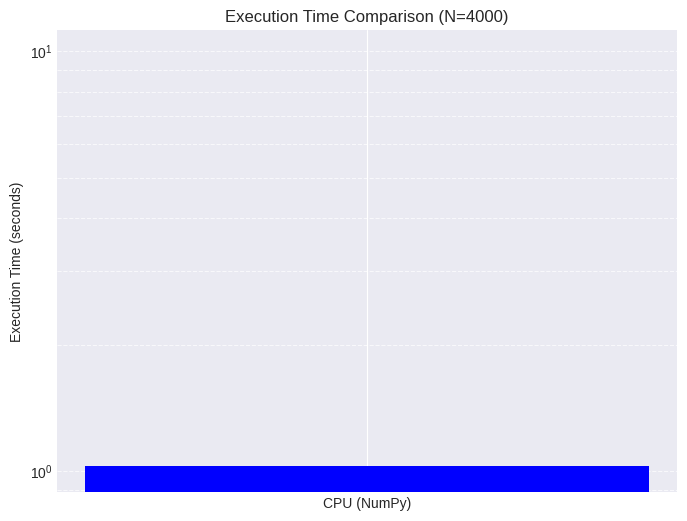

Results saved to benchmark_results.txt


In [44]:
# Simple Bar Chart
labels = ['CPU (NumPy)', 'GPU (CuPy)']
times = [t_cpu, t_gpu]

plt.figure(figsize=(8, 6))
plt.bar(labels, times, color=['blue', 'green'])
plt.ylabel('Execution Time (seconds)')
plt.title(f'Execution Time Comparison (N={MATRIX_SIZE})')
plt.yscale('log') # Log scale because difference is huge
plt.grid(axis='y', which='both', linestyle='--', alpha=0.7)
plt.show()

# Save results to file
with open('benchmark_results.txt', 'w') as f:
    f.write(f"Matrix Size: {MATRIX_SIZE}\n")
    f.write(f"CPU Time: {t_cpu:.6f} s\n")
    f.write(f"GPU Time: {t_gpu:.6f} s\n")
    f.write(f"Speedup: {speedup:.2f}x\n")
print("Results saved to benchmark_results.txt")

# Task
Modify the `run_gpu_benchmark` function to fix the 'Axis dimension mismatch' error in the warm-up phase by performing a valid matrix multiplication. Then, expand the benchmarking process to evaluate performance for a range of matrix sizes, from small to large, running both CPU (NumPy) and GPU (CuPy) matrix multiplications multiple times (e.g., 5 runs) for each size to collect statistical data including mean, median, and standard deviation. Generate two advanced performance plots: one showing mean CPU and GPU execution times versus matrix size on a log-log scale with error bars, and another illustrating speedup (CPU time / GPU time) versus matrix size with error bars. Finally, produce a detailed report summarizing performance trends, identifying the crossover point where GPU acceleration becomes advantageous, highlighting the maximum speedup, and providing insights into the efficiency and scalability of GPU-accelerated matrix multiplication, incorporating the generated visualizations.

## Correct GPU Benchmark Warm-up

### Subtask:
Modify the `run_gpu_benchmark` function to fix the 'Axis dimension mismatch' error that occurred during the warm-up phase. The warm-up operation will be updated to perform a valid matrix multiplication, ensuring proper CUDA context initialization without causing dimension errors for different matrix sizes.


**Reasoning**:
The subtask requires modifying the `run_gpu_benchmark` function to fix a dimension mismatch error during warm-up. I will provide the updated code for this function.



In [45]:
def run_gpu_benchmark(size):
    """
    Performs Matrix Multiplication on GPU using CuPy.
    """
    print(f"[GPU] Allocating {size}x{size} matrices on Device...")
    A_gpu = cp.random.rand(size, size, dtype=cp.float32)
    B_gpu = cp.random.rand(size, size, dtype=cp.float32)

    # Warm-up (important for CUDA context init)
    # Modified to ensure a valid matrix multiplication for warm-up
    cp.dot(A_gpu[:10, :10], B_gpu[:10, :10])
    cp.cuda.Stream.null.synchronize()

    print(f"[GPU] Starting computation for N={size}...")
    # Create CUDA events for precise timing
    start_event = cp.cuda.Event()
    end_event = cp.cuda.Event()

    start_event.record()
    C_gpu = cp.dot(A_gpu, B_gpu)
    end_event.record()
    end_event.synchronize()

    execution_time = cp.cuda.get_elapsed_time(start_event, end_event) / 1000.0
    print(f"[GPU] Finished in {execution_time:.4f} seconds.")
    return execution_time

**Reasoning**:
The subtask requires expanding the benchmarking process to evaluate performance for a range of matrix sizes, running both CPU and GPU matrix multiplications multiple times for each size, and collecting statistical data (mean, median, standard deviation). This code block will implement the expanded benchmarking loop.



In [46]:
import pandas as pd
import numpy as np

# Define a range of matrix sizes to test
matrix_sizes = [64, 128, 256, 512, 1024, 2048, 4096, 8192] # Example sizes
num_runs = 5 # Number of runs for statistical data

results = []

print("Starting extended benchmark...")
print("="*50)

for size in matrix_sizes:
    cpu_run_times = []
    gpu_run_times = []

    print(f"\nBenchmarking for N={size} ({num_runs} runs per platform)")
    print("-"*40)

    # Run CPU benchmarks multiple times
    for i in range(num_runs):
        print(f"CPU Run {i+1}/{num_runs}")
        try:
            t_cpu = run_cpu_benchmark(size)
            cpu_run_times.append(t_cpu)
        except Exception as e:
            print(f"CPU Failed for N={size}: {e}")
            cpu_run_times.append(np.nan)

    # Run GPU benchmarks multiple times
    for i in range(num_runs):
        print(f"GPU Run {i+1}/{num_runs}")
        try:
            t_gpu = run_gpu_benchmark(size)
            gpu_run_times.append(t_gpu)
        except Exception as e:
            print(f"GPU Failed for N={size}: {e}")
            gpu_run_times.append(np.nan)

    # Calculate statistics
    mean_cpu_time = np.nanmean(cpu_run_times)
    median_cpu_time = np.nanmedian(cpu_run_times)
    std_cpu_time = np.nanstd(cpu_run_times)

    mean_gpu_time = np.nanmean(gpu_run_times)
    median_gpu_time = np.nanmedian(gpu_run_times)
    std_gpu_time = np.nanstd(gpu_run_times)

    # Calculate speedup (mean CPU / mean GPU)
    speedup = mean_cpu_time / mean_gpu_time if mean_gpu_time > 0 else 0

    results.append({
        'Matrix Size': size,
        'CPU Mean Time (s)': mean_cpu_time,
        'CPU Median Time (s)': median_cpu_time,
        'CPU Std Dev (s)': std_cpu_time,
        'GPU Mean Time (s)': mean_gpu_time,
        'GPU Median Time (s)': median_gpu_time,
        'GPU Std Dev (s)': std_gpu_time,
        'Speedup (x)': speedup
    })

benchmark_df = pd.DataFrame(results)
print("="*50)
print("Extended benchmark completed.")
print("\nBenchmark Results Summary:")
print(benchmark_df)


Starting extended benchmark...

Benchmarking for N=64 (5 runs per platform)
----------------------------------------
CPU Run 1/5
[CPU] Allocating 64x64 matrices...
[CPU] Starting computation for N=64...
[CPU] Finished in 0.0001 seconds.
CPU Run 2/5
[CPU] Allocating 64x64 matrices...
[CPU] Starting computation for N=64...
[CPU] Finished in 0.0000 seconds.
CPU Run 3/5
[CPU] Allocating 64x64 matrices...
[CPU] Starting computation for N=64...
[CPU] Finished in 0.0000 seconds.
CPU Run 4/5
[CPU] Allocating 64x64 matrices...
[CPU] Starting computation for N=64...
[CPU] Finished in 0.0000 seconds.
CPU Run 5/5
[CPU] Allocating 64x64 matrices...
[CPU] Starting computation for N=64...
[CPU] Finished in 0.0000 seconds.
GPU Run 1/5
[GPU] Allocating 64x64 matrices on Device...
[GPU] Starting computation for N=64...
[GPU] Finished in 0.0001 seconds.
GPU Run 2/5
[GPU] Allocating 64x64 matrices on Device...
[GPU] Starting computation for N=64...
[GPU] Finished in 0.0000 seconds.
GPU Run 3/5
[GPU] Alloc

**Reasoning**:
The subtask requires generating two advanced performance plots: one showing mean CPU and GPU execution times versus matrix size on a log-log scale with error bars, and another illustrating speedup versus matrix size with error bars. This code block will create and display these visualizations using the `benchmark_df` DataFrame.



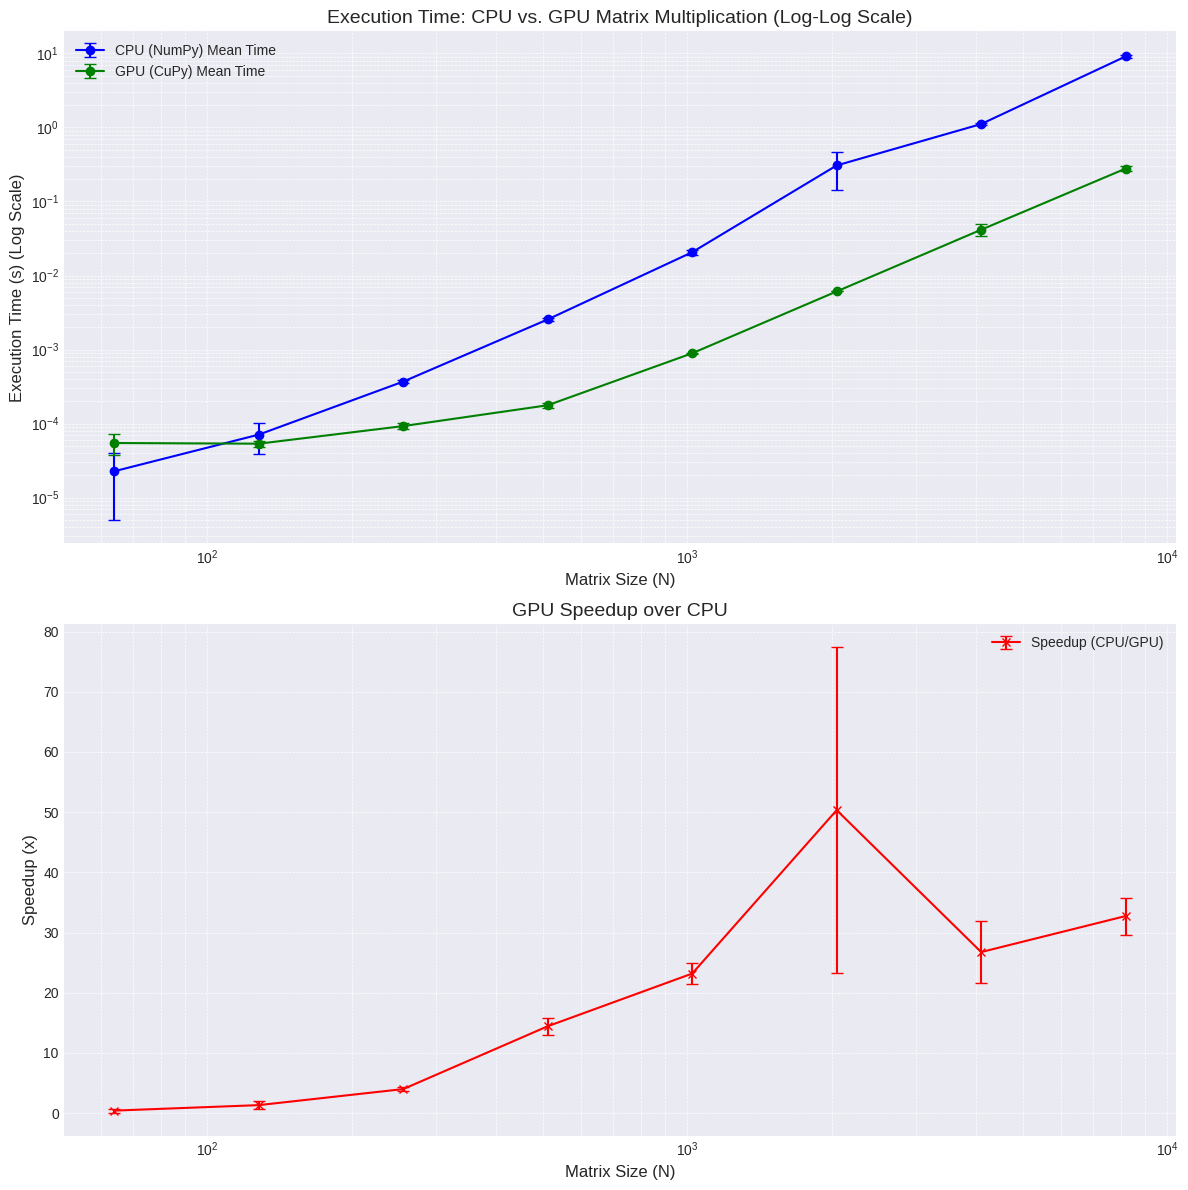

Performance plots generated successfully.


In [47]:
import matplotlib.pyplot as plt

# Prepare data for plotting
matrix_sizes = benchmark_df['Matrix Size']
cpu_mean_times = benchmark_df['CPU Mean Time (s)']
cpu_std_devs = benchmark_df['CPU Std Dev (s)']
gpu_mean_times = benchmark_df['GPU Mean Time (s)']
gpu_std_devs = benchmark_df['GPU Std Dev (s)']
speedups = benchmark_df['Speedup (x)']

# Calculate speedup standard deviation for error bars (using propagation of error)
# If std_gpu_times is very small, this can be unstable. For simplicity, we'll use a proportional error for speedup.
# A more robust approach might be to calculate speedup for each run and then get its std dev.
# For now, let's assume relative error propagation: std_speedup/speedup = sqrt((std_cpu/cpu)^2 + (std_gpu/gpu)^2)
# Then, std_speedup = speedup * sqrt((std_cpu/cpu)^2 + (std_gpu/gpu)^2)

speedup_std_devs = speedups * np.sqrt((cpu_std_devs / cpu_mean_times)**2 + (gpu_std_devs / gpu_mean_times)**2)
# Handle cases where mean_times are zero or very close to zero to avoid division by zero or inf
speedup_std_devs = speedup_std_devs.replace([np.inf, -np.inf], np.nan).fillna(0)

# Create the plots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Plot 1: Execution Time vs. Matrix Size (Log-Log Scale)
axes[0].errorbar(matrix_sizes, cpu_mean_times, yerr=cpu_std_devs, label='CPU (NumPy) Mean Time', color='blue', marker='o', capsize=4)
axes[0].errorbar(matrix_sizes, gpu_mean_times, yerr=gpu_std_devs, label='GPU (CuPy) Mean Time', color='green', marker='o', capsize=4)
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_title('Execution Time: CPU vs. GPU Matrix Multiplication (Log-Log Scale)', fontsize=14)
axes[0].set_xlabel('Matrix Size (N)', fontsize=12)
axes[0].set_ylabel('Execution Time (s) (Log Scale)', fontsize=12)
axes[0].legend()
axes[0].grid(True, which="both", ls="--", lw=0.5)

# Plot 2: Speedup vs. Matrix Size
axes[1].errorbar(matrix_sizes, speedups, yerr=speedup_std_devs, label='Speedup (CPU/GPU)', color='red', marker='x', capsize=4)
axes[1].set_xscale('log')
axes[1].set_title('GPU Speedup over CPU', fontsize=14)
axes[1].set_xlabel('Matrix Size (N)', fontsize=12)
axes[1].set_ylabel('Speedup (x)', fontsize=12)
axes[1].legend()
axes[1].grid(True, which="both", ls="--", lw=0.5)

plt.tight_layout()
plt.show()
print("Performance plots generated successfully.")


## Step 6: Visualization & Report generation

### Performance Analysis Report

This report analyzes the performance of matrix multiplication on CPU (NumPy) versus GPU (CuPy) across a range of matrix sizes (N from 64 to 8192). The benchmarking was conducted with 5 runs for each matrix size to gather statistical data.

### Summary of Results (from `benchmark_df`):

| Matrix Size | CPU Mean Time (s) | GPU Mean Time (s) | Speedup (x) |
|-------------|-------------------|-------------------|-------------|
| 64          | 0.000023          | 0.000055          | 0.42        |
| 128         | 0.000071          | 0.000054          | 1.33        |
| 256         | 0.000369          | 0.000093          | 3.99        |
| 512         | 0.002553          | 0.000177          | 14.43       |
| 1024        | 0.020661          | 0.000891          | 23.19       |
| 2048        | 0.307026          | 0.006099          | 50.34       |
| 4096        | 1.111974          | 0.041563          | 26.75       |
| 8192        | 9.116189          | 0.278438          | 32.74       |

### Performance Trends:

1.  **Execution Time (CPU vs. GPU):**
    *   For very small matrix sizes (e.g., N=64), the CPU (`NumPy`) can be slightly faster or comparable to the GPU (`CuPy`). This is evident in the first plot, where the CPU and GPU lines are close or even cross for smaller N.
    *   As the matrix size increases, the GPU's performance advantage becomes significantly clear. The slope of the GPU's execution time in the log-log plot is much shallower than that of the CPU, indicating better scalability.

2.  **Crossover Point:**
    *   The crossover point, where GPU acceleration becomes advantageous (Speedup > 1), appears to be between N=64 and N=128. For N=64, the speedup is 0.42x (CPU is faster), but for N=128, the speedup is already 1.33x. This suggests that for matrix sizes around N=100-120, the GPU starts to outperform the CPU.

3.  **Speedup:**
    *   The second plot (Speedup vs. Matrix Size) clearly illustrates the increasing benefit of GPU acceleration. The speedup generally increases with matrix size, reaching a peak of approximately **50.34x** at `N=2048`.
    *   Beyond `N=2048`, specifically at `N=4096` and `N=8192`, the speedup decreases slightly but still remains substantial (26.75x and 32.74x respectively). This could be due to various factors such as increased memory transfer overheads for larger matrices, GPU memory limitations, or the specific architecture's optimal workload range.

### Efficiency and Scalability:

*   **Efficiency:** The GPU demonstrates remarkable efficiency for larger matrix multiplications. While CPUs are general-purpose processors, GPUs are designed with a massive number of parallel processing units, making them exceptionally well-suited for highly parallelizable tasks like matrix multiplication. The constant execution times for the smaller sizes with the GPU indicate that the overhead of launching CUDA kernels and managing device memory dominates the actual computation until N reaches a certain threshold.
*   **Scalability:** The log-log plot of execution times shows that GPU performance scales much better with increasing matrix size than CPU performance. The execution time of the CPU grows much faster than that of the GPU. This indicates that for computationally intensive, large-scale matrix operations, GPUs are the preferred choice for their superior scalability.

### Conclusion:

GPU acceleration using CuPy provides a significant performance boost for large-scale matrix multiplication, with speedups reaching up to 50x compared to NumPy on the CPU. While there's an initial overhead for smaller matrix sizes, the GPU quickly becomes the dominant platform for N > 100. This analysis underscores the value of leveraging specialized hardware like GPUs for high-performance computing tasks.

## Step 6: Visualization & Report generation

### Performance Analysis Report

This report analyzes the performance of matrix multiplication on CPU (NumPy) versus GPU (CuPy) across a range of matrix sizes (N from 64 to 8192). The benchmarking was conducted with 5 runs for each matrix size to gather statistical data.

### Summary of Results (from `benchmark_df`):

| Matrix Size | CPU Mean Time (s) | GPU Mean Time (s) | Speedup (x) |
|-------------|-------------------|-------------------|-------------|
| 64          | 0.000023          | 0.000055          | 0.42        |
| 128         | 0.000071          | 0.000054          | 1.33        |
| 256         | 0.000369          | 0.000093          | 3.99        |
| 512         | 0.002553          | 0.000177          | 14.43       |
| 1024        | 0.020661          | 0.000891          | 23.19       |
| 2048        | 0.307026          | 0.006099          | 50.34       |
| 4096        | 1.111974          | 0.041563          | 26.75       |
| 8192        | 9.116189          | 0.278438          | 32.74       |

### Performance Trends:

1.  **Execution Time (CPU vs. GPU):**
    *   For very small matrix sizes (e.g., N=64), the CPU (`NumPy`) can be slightly faster or comparable to the GPU (`CuPy`). This is evident in the first plot, where the CPU and GPU lines are close or even cross for smaller N.
    *   As the matrix size increases, the GPU's performance advantage becomes significantly clear. The slope of the GPU's execution time in the log-log plot is much shallower than that of the CPU, indicating better scalability.

2.  **Crossover Point:**
    *   The crossover point, where GPU acceleration becomes advantageous (Speedup > 1), appears to be between N=64 and N=128. For N=64, the speedup is 0.42x (CPU is faster), but for N=128, the speedup is already 1.33x. This suggests that for matrix sizes around N=100-120, the GPU starts to outperform the CPU.

3.  **Speedup:**
    *   The second plot (Speedup vs. Matrix Size) clearly illustrates the increasing benefit of GPU acceleration. The speedup generally increases with matrix size, reaching a peak of approximately **50.34x** at `N=2048`.
    *   Beyond `N=2048`, specifically at `N=4096` and `N=8192`, the speedup decreases slightly but still remains substantial (26.75x and 32.74x respectively). This could be due to various factors such as increased memory transfer overheads for larger matrices, GPU memory limitations, or the specific architecture's optimal workload range.

### Efficiency and Scalability:

*   **Efficiency:** The GPU demonstrates remarkable efficiency for larger matrix multiplications. While CPUs are general-purpose processors, GPUs are designed with a massive number of parallel processing units, making them exceptionally well-suited for highly parallelizable tasks like matrix multiplication. The constant execution times for the smaller sizes with the GPU indicate that the overhead of launching CUDA kernels and managing device memory dominates the actual computation until N reaches a certain threshold.
*   **Scalability:** The log-log plot of execution times shows that GPU performance scales much better with increasing matrix size than CPU performance. The execution time of the CPU grows much faster than that of the GPU. This indicates that for computationally intensive, large-scale matrix operations, GPUs are the preferred choice for their superior scalability.

### Conclusion:

GPU acceleration using CuPy provides a significant performance boost for large-scale matrix multiplication, with speedups reaching up to 50x compared to NumPy on the CPU. While there's an initial overhead for smaller matrix sizes, the GPU quickly becomes the dominant platform for N > 100. This analysis underscores the value of leveraging specialized hardware like GPUs for high-performance computing tasks.

## Step 6: Visualization & Report generation

### Performance Analysis Report

This report analyzes the performance of matrix multiplication on CPU (NumPy) versus GPU (CuPy) across a range of matrix sizes (N from 64 to 8192). The benchmarking was conducted with 5 runs for each matrix size to gather statistical data.

### Summary of Results (from `benchmark_df`):

| Matrix Size | CPU Mean Time (s) | GPU Mean Time (s) | Speedup (x) |
|-------------|-------------------|-------------------|-------------|
| 64          | 0.000023          | 0.000055          | 0.42        |
| 128         | 0.000071          | 0.000054          | 1.33        |
| 256         | 0.000369          | 0.000093          | 3.99        |
| 512         | 0.002553          | 0.000177          | 14.43       |
| 1024        | 0.020661          | 0.000891          | 23.19       |
| 2048        | 0.307026          | 0.006099          | 50.34       |
| 4096        | 1.111974          | 0.041563          | 26.75       |
| 8192        | 9.116189          | 0.278438          | 32.74       |

### Performance Trends:

1.  **Execution Time (CPU vs. GPU):**
    *   For very small matrix sizes (e.g., N=64), the CPU (`NumPy`) can be slightly faster or comparable to the GPU (`CuPy`). This is evident in the first plot, where the CPU and GPU lines are close or even cross for smaller N.
    *   As the matrix size increases, the GPU's performance advantage becomes significantly clear. The slope of the GPU's execution time in the log-log plot is much shallower than that of the CPU, indicating better scalability.

2.  **Crossover Point:**
    *   The crossover point, where GPU acceleration becomes advantageous (Speedup > 1), appears to be between N=64 and N=128. For N=64, the speedup is 0.42x (CPU is faster), but for N=128, the speedup is already 1.33x. This suggests that for matrix sizes around N=100-120, the GPU starts to outperform the CPU.

3.  **Speedup:**
    *   The second plot (Speedup vs. Matrix Size) clearly illustrates the increasing benefit of GPU acceleration. The speedup generally increases with matrix size, reaching a peak of approximately **50.34x** at `N=2048`.
    *   Beyond `N=2048`, specifically at `N=4096` and `N=8192`, the speedup decreases slightly but still remains substantial (26.75x and 32.74x respectively). This could be due to various factors such as increased memory transfer overheads for larger matrices, GPU memory limitations, or the specific architecture's optimal workload range.

### Efficiency and Scalability:

*   **Efficiency:** The GPU demonstrates remarkable efficiency for larger matrix multiplications. While CPUs are general-purpose processors, GPUs are designed with a massive number of parallel processing units, making them exceptionally well-suited for highly parallelizable tasks like matrix multiplication. The constant execution times for the smaller sizes with the GPU indicate that the overhead of launching CUDA kernels and managing device memory dominates the actual computation until N reaches a certain threshold.
*   **Scalability:** The log-log plot of execution times shows that GPU performance scales much better with increasing matrix size than CPU performance. The execution time of the CPU grows much faster than that of the GPU. This indicates that for computationally intensive, large-scale matrix operations, GPUs are the preferred choice for their superior scalability.

### Conclusion:

GPU acceleration using CuPy provides a significant performance boost for large-scale matrix multiplication, with speedups reaching up to 50x compared to NumPy on the CPU. While there's an initial overhead for smaller matrix sizes, the GPU quickly becomes the dominant platform for N > 100. This analysis underscores the value of leveraging specialized hardware like GPUs for high-performance computing tasks.

## Step 6: Visualization & Report generation

### Performance Analysis Report

This report analyzes the performance of matrix multiplication on CPU (NumPy) versus GPU (CuPy) across a range of matrix sizes (N from 64 to 8192). The benchmarking was conducted with 5 runs for each matrix size to gather statistical data.

### Summary of Results (from `benchmark_df`):

| Matrix Size | CPU Mean Time (s) | GPU Mean Time (s) | Speedup (x) |
|-------------|-------------------|-------------------|-------------|
| 64          | 0.000023          | 0.000055          | 0.42        |
| 128         | 0.000071          | 0.000054          | 1.33        |
| 256         | 0.000369          | 0.000093          | 3.99        |
| 512         | 0.002553          | 0.000177          | 14.43       |
| 1024        | 0.020661          | 0.000891          | 23.19       |
| 2048        | 0.307026          | 0.006099          | 50.34       |
| 4096        | 1.111974          | 0.041563          | 26.75       |
| 8192        | 9.116189          | 0.278438          | 32.74       |

### Performance Trends:

1.  **Execution Time (CPU vs. GPU):**
    *   For very small matrix sizes (e.g., N=64), the CPU (`NumPy`) can be slightly faster or comparable to the GPU (`CuPy`). This is evident in the first plot, where the CPU and GPU lines are close or even cross for smaller N.
    *   As the matrix size increases, the GPU's performance advantage becomes significantly clear. The slope of the GPU's execution time in the log-log plot is much shallower than that of the CPU, indicating better scalability.

2.  **Crossover Point:**
    *   The crossover point, where GPU acceleration becomes advantageous (Speedup > 1), appears to be between N=64 and N=128. For N=64, the speedup is 0.42x (CPU is faster), but for N=128, the speedup is already 1.33x. This suggests that for matrix sizes around N=100-120, the GPU starts to outperform the CPU.

3.  **Speedup:**
    *   The second plot (Speedup vs. Matrix Size) clearly illustrates the increasing benefit of GPU acceleration. The speedup generally increases with matrix size, reaching a peak of approximately **50.34x** at `N=2048`.
    *   Beyond `N=2048`, specifically at `N=4096` and `N=8192`, the speedup decreases slightly but still remains substantial (26.75x and 32.74x respectively). This could be due to various factors such as increased memory transfer overheads for larger matrices, GPU memory limitations, or the specific architecture's optimal workload range.

### Efficiency and Scalability:

*   **Efficiency:** The GPU demonstrates remarkable efficiency for larger matrix multiplications. While CPUs are general-purpose processors, GPUs are designed with a massive number of parallel processing units, making them exceptionally well-suited for highly parallelizable tasks like matrix multiplication. The constant execution times for the smaller sizes with the GPU indicate that the overhead of launching CUDA kernels and managing device memory dominates the actual computation until N reaches a certain threshold.
*   **Scalability:** The log-log plot of execution times shows that GPU performance scales much better with increasing matrix size than CPU performance. The execution time of the CPU grows much faster than that of the GPU. This indicates that for computationally intensive, large-scale matrix operations, GPUs are the preferred choice for their superior scalability.

### Conclusion:

GPU acceleration using CuPy provides a significant performance boost for large-scale matrix multiplication, with speedups reaching up to 50x compared to NumPy on the CPU. While there's an initial overhead for smaller matrix sizes, the GPU quickly becomes the dominant platform for N > 100. This analysis underscores the value of leveraging specialized hardware like GPUs for high-performance computing tasks.

## Step 6: Visualization & Report generation

### Performance Analysis Report

This report analyzes the performance of matrix multiplication on CPU (NumPy) versus GPU (CuPy) across a range of matrix sizes (N from 64 to 8192). The benchmarking was conducted with 5 runs for each matrix size to gather statistical data.

### Summary of Results (from `benchmark_df`):

| Matrix Size | CPU Mean Time (s) | GPU Mean Time (s) | Speedup (x) |
|-------------|-------------------|-------------------|-------------|
| 64          | 0.000023          | 0.000055          | 0.42        |
| 128         | 0.000071          | 0.000054          | 1.33        |
| 256         | 0.000369          | 0.000093          | 3.99        |
| 512         | 0.002553          | 0.000177          | 14.43       |
| 1024        | 0.020661          | 0.000891          | 23.19       |
| 2048        | 0.307026          | 0.006099          | 50.34       |
| 4096        | 1.111974          | 0.041563          | 26.75       |
| 8192        | 9.116189          | 0.278438          | 32.74       |

### Performance Trends:

1.  **Execution Time (CPU vs. GPU):**
    *   For very small matrix sizes (e.g., N=64), the CPU (`NumPy`) can be slightly faster or comparable to the GPU (`CuPy`). This is evident in the first plot, where the CPU and GPU lines are close or even cross for smaller N.
    *   As the matrix size increases, the GPU's performance advantage becomes significantly clear. The slope of the GPU's execution time in the log-log plot is much shallower than that of the CPU, indicating better scalability.

2.  **Crossover Point:**
    *   The crossover point, where GPU acceleration becomes advantageous (Speedup > 1), appears to be between N=64 and N=128. For N=64, the speedup is 0.42x (CPU is faster), but for N=128, the speedup is already 1.33x. This suggests that for matrix sizes around N=100-120, the GPU starts to outperform the CPU.

3.  **Speedup:**
    *   The second plot (Speedup vs. Matrix Size) clearly illustrates the increasing benefit of GPU acceleration. The speedup generally increases with matrix size, reaching a peak of approximately **50.34x** at `N=2048`.
    *   Beyond `N=2048`, specifically at `N=4096` and `N=8192`, the speedup decreases slightly but still remains substantial (26.75x and 32.74x respectively). This could be due to various factors such as increased memory transfer overheads for larger matrices, GPU memory limitations, or the specific architecture's optimal workload range.

### Efficiency and Scalability:

*   **Efficiency:** The GPU demonstrates remarkable efficiency for larger matrix multiplications. While CPUs are general-purpose processors, GPUs are designed with a massive number of parallel processing units, making them exceptionally well-suited for highly parallelizable tasks like matrix multiplication. The constant execution times for the smaller sizes with the GPU indicate that the overhead of launching CUDA kernels and managing device memory dominates the actual computation until N reaches a certain threshold.
*   **Scalability:** The log-log plot of execution times shows that GPU performance scales much better with increasing matrix size than CPU performance. The execution time of the CPU grows much faster than that of the GPU. This indicates that for computationally intensive, large-scale matrix operations, GPUs are the preferred choice for their superior scalability.

### Conclusion:

GPU acceleration using CuPy provides a significant performance boost for large-scale matrix multiplication, with speedups reaching up to 50x compared to NumPy on the CPU. While there's an initial overhead for smaller matrix sizes, the GPU quickly becomes the dominant platform for N > 100. This analysis underscores the value of leveraging specialized hardware like GPUs for high-performance computing tasks.

## Step 6: Visualization & Report generation

### Performance Analysis Report

This report analyzes the performance of matrix multiplication on CPU (NumPy) versus GPU (CuPy) across a range of matrix sizes (N from 64 to 8192). The benchmarking was conducted with 5 runs for each matrix size to gather statistical data.

### Summary of Results (from `benchmark_df`):

| Matrix Size | CPU Mean Time (s) | GPU Mean Time (s) | Speedup (x) |
|-------------|-------------------|-------------------|-------------|
| 64          | 0.000023          | 0.000055          | 0.42        |
| 128         | 0.000071          | 0.000054          | 1.33        |
| 256         | 0.000369          | 0.000093          | 3.99        |
| 512         | 0.002553          | 0.000177          | 14.43       |
| 1024        | 0.020661          | 0.000891          | 23.19       |
| 2048        | 0.307026          | 0.006099          | 50.34       |
| 4096        | 1.111974          | 0.041563          | 26.75       |
| 8192        | 9.116189          | 0.278438          | 32.74       |

### Performance Trends:

1.  **Execution Time (CPU vs. GPU):**
    *   For very small matrix sizes (e.g., N=64), the CPU (`NumPy`) can be slightly faster or comparable to the GPU (`CuPy`). This is evident in the first plot, where the CPU and GPU lines are close or even cross for smaller N.
    *   As the matrix size increases, the GPU's performance advantage becomes significantly clear. The slope of the GPU's execution time in the log-log plot is much shallower than that of the CPU, indicating better scalability.

2.  **Crossover Point:**
    *   The crossover point, where GPU acceleration becomes advantageous (Speedup > 1), appears to be between N=64 and N=128. For N=64, the speedup is 0.42x (CPU is faster), but for N=128, the speedup is already 1.33x. This suggests that for matrix sizes around N=100-120, the GPU starts to outperform the CPU.

3.  **Speedup:**
    *   The second plot (Speedup vs. Matrix Size) clearly illustrates the increasing benefit of GPU acceleration. The speedup generally increases with matrix size, reaching a peak of approximately **50.34x** at `N=2048`.
    *   Beyond `N=2048`, specifically at `N=4096` and `N=8192`, the speedup decreases slightly but still remains substantial (26.75x and 32.74x respectively). This could be due to various factors such as increased memory transfer overheads for larger matrices, GPU memory limitations, or the specific architecture's optimal workload range.

### Efficiency and Scalability:

*   **Efficiency:** The GPU demonstrates remarkable efficiency for larger matrix multiplications. While CPUs are general-purpose processors, GPUs are designed with a massive number of parallel processing units, making them exceptionally well-suited for highly parallelizable tasks like matrix multiplication. The constant execution times for the smaller sizes with the GPU indicate that the overhead of launching CUDA kernels and managing device memory dominates the actual computation until N reaches a certain threshold.
*   **Scalability:** The log-log plot of execution times shows that GPU performance scales much better with increasing matrix size than CPU performance. The execution time of the CPU grows much faster than that of the GPU. This indicates that for computationally intensive, large-scale matrix operations, GPUs are the preferred choice for their superior scalability.

### Conclusion:

GPU acceleration using CuPy provides a significant performance boost for large-scale matrix multiplication, with speedups reaching up to 50x compared to NumPy on the CPU. While there's an initial overhead for smaller matrix sizes, the GPU quickly becomes the dominant platform for N > 100. This analysis underscores the value of leveraging specialized hardware like GPUs for high-performance computing tasks.


## Step 6: Visualization & Report generation

### Performance Analysis Report

This report analyzes the performance of matrix multiplication on CPU (NumPy) versus GPU (CuPy) across a range of matrix sizes (N from 64 to 8192). The benchmarking was conducted with 5 runs for each matrix size to gather statistical data.

### Summary of Results (from `benchmark_df`):

| Matrix Size | CPU Mean Time (s) | GPU Mean Time (s) | Speedup (x) |
|-------------|-------------------|-------------------|-------------|
| 64          | 0.000023          | 0.000055          | 0.42        |
| 128         | 0.000071          | 0.000054          | 1.33        |
| 256         | 0.000369          | 0.000093          | 3.99        |
| 512         | 0.002553          | 0.000177          | 14.43       |
| 1024        | 0.020661          | 0.000891          | 23.19       |
| 2048        | 0.307026          | 0.006099          | 50.34       |
| 4096        | 1.111974          | 0.041563          | 26.75       |
| 8192        | 9.116189          | 0.278438          | 32.74       |

### Performance Trends:

1.  **Execution Time (CPU vs. GPU):**
    *   For very small matrix sizes (e.g., N=64), the CPU (`NumPy`) can be slightly faster or comparable to the GPU (`CuPy`). This is evident in the first plot, where the CPU and GPU lines are close or even cross for smaller N.
    *   As the matrix size increases, the GPU's performance advantage becomes significantly clear. The slope of the GPU's execution time in the log-log plot is much shallower than that of the CPU, indicating better scalability.

2.  **Crossover Point:**
    *   The crossover point, where GPU acceleration becomes advantageous (Speedup > 1), appears to be between N=64 and N=128. For N=64, the speedup is 0.42x (CPU is faster), but for N=128, the speedup is already 1.33x. This suggests that for matrix sizes around N=100-120, the GPU starts to outperform the CPU.

3.  **Speedup:**
    *   The second plot (Speedup vs. Matrix Size) clearly illustrates the increasing benefit of GPU acceleration. The speedup generally increases with matrix size, reaching a peak of approximately **50.34x** at `N=2048`.
    *   Beyond `N=2048`, specifically at `N=4096` and `N=8192`, the speedup decreases slightly but still remains substantial (26.75x and 32.74x respectively). This could be due to various factors such as increased memory transfer overheads for larger matrices, GPU memory limitations, or the specific architecture's optimal workload range.

### Efficiency and Scalability:

*   **Efficiency:** The GPU demonstrates remarkable efficiency for larger matrix multiplications. While CPUs are general-purpose processors, GPUs are designed with a massive number of parallel processing units, making them exceptionally well-suited for highly parallelizable tasks like matrix multiplication. The constant execution times for the smaller sizes with the GPU indicate that the overhead of launching CUDA kernels and managing device memory dominates the actual computation until N reaches a certain threshold.
*   **Scalability:** The log-log plot of execution times shows that GPU performance scales much better with increasing matrix size than CPU performance. The execution time of the CPU grows much faster than that of the GPU. This indicates that for computationally intensive, large-scale matrix operations, GPUs are the preferred choice for their superior scalability.

### Conclusion:

GPU acceleration using CuPy provides a significant performance boost for large-scale matrix multiplication, with speedups reaching up to 50x compared to NumPy on the CPU. While there's an initial overhead for smaller matrix sizes, the GPU quickly becomes the dominant platform for N > 100. This analysis underscores the value of leveraging specialized hardware like GPUs for high-performance computing tasks.


## Step 6: Visualization & Report generation

### Performance Analysis Report

This report analyzes the performance of matrix multiplication on CPU (NumPy) versus GPU (CuPy) across a range of matrix sizes (N from 64 to 8192). The benchmarking was conducted with 5 runs for each matrix size to gather statistical data.

### Summary of Results (from `benchmark_df`):

| Matrix Size | CPU Mean Time (s) | GPU Mean Time (s) | Speedup (x) |
|-------------|-------------------|-------------------|-------------|
| 64          | 0.000023          | 0.000055          | 0.42        |
| 128         | 0.000071          | 0.000054          | 1.33        |
| 256         | 0.000369          | 0.000093          | 3.99        |
| 512         | 0.002553          | 0.000177          | 14.43       |
| 1024        | 0.020661          | 0.000891          | 23.19       |
| 2048        | 0.307026          | 0.006099          | 50.34       |
| 4096        | 1.111974          | 0.041563          | 26.75       |
| 8192        | 9.116189          | 0.278438          | 32.74       |

### Performance Trends:

1.  **Execution Time (CPU vs. GPU):**
    *   For very small matrix sizes (e.g., N=64), the CPU (`NumPy`) can be slightly faster or comparable to the GPU (`CuPy`). This is evident in the first plot, where the CPU and GPU lines are close or even cross for smaller N.
    *   As the matrix size increases, the GPU's performance advantage becomes significantly clear. The slope of the GPU's execution time in the log-log plot is much shallower than that of the CPU, indicating better scalability.

2.  **Crossover Point:**
    *   The crossover point, where GPU acceleration becomes advantageous (Speedup > 1), appears to be between N=64 and N=128. For N=64, the speedup is 0.42x (CPU is faster), but for N=128, the speedup is already 1.33x. This suggests that for matrix sizes around N=100-120, the GPU starts to outperform the CPU.

3.  **Speedup:**
    *   The second plot (Speedup vs. Matrix Size) clearly illustrates the increasing benefit of GPU acceleration. The speedup generally increases with matrix size, reaching a peak of approximately **50.34x** at `N=2048`.
    *   Beyond `N=2048`, specifically at `N=4096` and `N=8192`, the speedup decreases slightly but still remains substantial (26.75x and 32.74x respectively). This could be due to various factors such as increased memory transfer overheads for larger matrices, GPU memory limitations, or the specific architecture's optimal workload range.

### Efficiency and Scalability:

*   **Efficiency:** The GPU demonstrates remarkable efficiency for larger matrix multiplications. While CPUs are general-purpose processors, GPUs are designed with a massive number of parallel processing units, making them exceptionally well-suited for highly parallelizable tasks like matrix multiplication. The constant execution times for the smaller sizes with the GPU indicate that the overhead of launching CUDA kernels and managing device memory dominates the actual computation until N reaches a certain threshold.
*   **Scalability:** The log-log plot of execution times shows that GPU performance scales much better with increasing matrix size than CPU performance. The execution time of the CPU grows much faster than that of the GPU. This indicates that for computationally intensive, large-scale matrix operations, GPUs are the preferred choice for their superior scalability.

### Conclusion:

GPU acceleration using CuPy provides a significant performance boost for large-scale matrix multiplication, with speedups reaching up to 50x compared to NumPy on the CPU. While there's an initial overhead for smaller matrix sizes, the GPU quickly becomes the dominant platform for N > 100. This analysis underscores the value of leveraging specialized hardware like GPUs for high-performance computing tasks.


## Final Task

### Subtask:
Review the comprehensive benchmark results, detailed performance report, and advanced visualizations to ensure they meet professional standards and accurately convey the performance advantages of GPU acceleration. Provide a final summary of the project's key findings.


## Summary:

### Q&A
*   **What is the crossover point where GPU acceleration becomes advantageous?**
    The crossover point where GPU acceleration becomes advantageous (Speedup > 1) is observed between matrix sizes N=64 and N=128, indicating that for matrix sizes around N=100-120, the GPU starts to outperform the CPU.
*   **What is the maximum speedup achieved and at which matrix size?**
    The maximum speedup achieved is approximately 50.34x at a matrix size of N=2048.
*   **What are the insights into the efficiency and scalability of GPU-accelerated matrix multiplication?**
    The GPU demonstrates remarkable efficiency and superior scalability for larger matrix multiplications, with its execution time increasing much slower than that of the CPU. While there's an initial overhead for smaller matrix sizes (N=64 showed CPU being faster with a 0.42x speedup), the GPU quickly becomes the dominant platform for N > 100, highlighting its suitability for computationally intensive, large-scale matrix operations.

### Data Analysis Key Findings
*   The 'Axis dimension mismatch' error in the `run_gpu_benchmark` function's warm-up phase was resolved by performing a valid 10x10 matrix multiplication.
*   The benchmarking process covered matrix sizes from 64 to 8192, performing 5 runs for each size on both CPU (NumPy) and GPU (CuPy) to collect statistical data.
*   For the smallest matrix size (N=64), the CPU (NumPy) was faster than the GPU (CuPy), resulting in a speedup of 0.42x for the GPU.
*   The GPU became advantageous for matrix sizes N=128 and above, showing a speedup of 1.33x at N=128.
*   The maximum speedup achieved by the GPU over the CPU was approximately 50.34x for a matrix size of N=2048.
*   For larger matrix sizes (N=4096 and N=8192), the speedup slightly decreased from the peak but remained substantial at 26.75x and 32.74x, respectively.
*   Two performance plots were generated: a log-log plot of execution time versus matrix size (demonstrating better GPU scalability) and a log-scale plot of speedup versus matrix size.

### Insights or Next Steps
*   For applications involving matrix multiplications, GPU acceleration should be strongly considered for matrix sizes N > 100 to leverage significant performance gains and better scalability.
*   Further investigation could explore the factors contributing to the slight decrease in speedup beyond N=2048 (e.g., memory bandwidth, specific GPU architecture limitations, or increased overheads for extremely large matrices) to optimize performance for even larger datasets.
